In [5]:
from google.colab import drive
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
from collections import Counter
import os

In [4]:
from google.colab import drive
import zipfile
import os

#Mount Google Drive
drive.mount('/content/drive')

#Paths
#zip_path = "/content/drive/MyDrive/deep_dataset.zip"
#extract_path = "/content/drive/MyDrive"
#dataset_path = "/content/drive/MyDrive/deep_dataset"

#Extract only once
#if not os.path.exists(dataset_path):
    #with zipfile.ZipFile(zip_path, "r") as zip_ref:
        #zip_ref.extractall(extract_path)
    #print("Dataset extracted successfully into MyDrive!")
#else:
    #print("Dataset already exists in MyDrive. Skipping extraction.")


Mounted at /content/drive


In [24]:
!ls /content/drive/MyDrive/deep_dataset_splits

test  train  val


In [25]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 5  ##new

BASE_SPLIT_DIR = "/content/drive/MyDrive/deep_dataset_splits"


train_ds = tf.keras.utils.image_dataset_from_directory(
    f"{BASE_SPLIT_DIR}/train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int",
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    f"{BASE_SPLIT_DIR}/val",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int",
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    f"{BASE_SPLIT_DIR}/test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int",
    shuffle=False
)

class_names = train_ds.class_names
print("Classes:", class_names)


Found 1657 files belonging to 5 classes.
Found 355 files belonging to 5 classes.
Found 358 files belonging to 5 classes.
Classes: ['building', 'car', 'lab', 'person', 'tree']


In [26]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)


import numpy as np
from collections import Counter
# نجمع كل اللابلز من train
train_labels = []

for _, labels in train_ds:
    train_labels.extend(labels.numpy())

# نحسب عدد العينات بكل كلاس
counter = Counter(train_labels)
print("Samples per class:", counter)

num_classes = len(counter)
total_samples = len(train_labels)

# حساب class weights
class_weights = {
    cls: total_samples / (num_classes * count)
    for cls, count in counter.items()
}

print("Class Weights:", class_weights)


Samples per class: Counter({np.int32(4): 406, np.int32(1): 364, np.int32(2): 313, np.int32(3): 308, np.int32(0): 266})
Class Weights: {np.int32(4): 0.816256157635468, np.int32(3): 1.075974025974026, np.int32(0): 1.2458646616541353, np.int32(1): 0.9104395604395604, np.int32(2): 1.0587859424920127}


In [27]:
# import tensorflow as tf
# tf.keras.backend.clear_session()

In [28]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

from tensorflow.keras import layers, models, regularizers

NUM_CLASSES = 5
def se_block(x, reduction=16):
    channels = x.shape[-1]
    se = layers.GlobalAveragePooling2D()(x)
    se = layers.Dense(channels // reduction, activation="relu")(se)
    se = layers.Dense(channels, activation="sigmoid")(se)
    se = layers.Reshape((1, 1, channels))(se)
    return layers.Multiply()([x, se])

# Backbone
base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)


base_model.trainable = True #in large layer

for layer in base_model.layers[:-40]: #false with small layer
    layer.trainable = False

# Model
inputs = layers.Input(shape=(224, 224, 3))

x = preprocess_input(inputs)
x = base_model(x, training=False)

##### new
x = se_block(x)

x = layers.GlobalAveragePooling2D()(x)



x = layers.Dense(
    256,
    activation="relu",
    kernel_regularizer=regularizers.l2(1e-4)
)(x)

x = layers.BatchNormalization()(x) #new
x = layers.Activation("relu")(x)#new
x = layers.Dropout(0.3)(x)#0.3

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)  # back to normal


model_effnet = models.Model(inputs, outputs)

model_effnet.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 7, 7,      │  4,049,571 │ input_layer_1[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 80)        │    102,480 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1280)      │    103,680 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1,      │          0 │ dense_1[0][0]     │
│                     │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 7, 7,      │          0 │ efficientnetb0[0… │
│                     │ 1280)             │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ multiply[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    327,936 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 5)         │      1,285 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,585,976 (17.49 MB)

 Trainable params: 2,586,597 (9.87 MB)

 Non-trainable params: 1,999,379 (7.63 MB)

In [29]:
import tensorflow as tf
#from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model_effnet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)


early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=3,
    min_lr=1e-6
)

history = model_effnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=45,
    class_weight=class_weights,
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/45
52/52 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.4880 - loss: 1.3932 - val_accuracy: 0.9239 - val_loss: 0.9760 - learning_rate: 1.0000e-04
Epoch 2/45
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9234 - loss: 0.2909 - val_accuracy: 0.9577 - val_loss: 0.7432 - learning_rate: 1.0000e-04
Epoch 3/45
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.9630 - loss: 0.1819 - val_accuracy: 0.9690 - val_loss: 0.5716 - learning_rate: 1.0000e-04
Epoch 4/45
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9752 - loss: 0.1359 - val_accuracy: 0.9718 - val_loss: 0.4178 - learning_rate: 1.0000e-04
Epoch 5/45
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9877 - loss: 0.1101 - val_accuracy: 0.9690 - val_loss: 0.2989 - learning_rate: 1.0000e-04
Epoch 6/45
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9901 - loss: 0.0953 - val_accuracy: 0.9746 - val_loss: 0.2180 - learning_rate: 1.0000e-04
Epoch 7/45
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.9947 -

In [30]:
import numpy as np

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model_effnet.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


In [31]:
#Test Accuracy
from sklearn.metrics import accuracy_score, classification_report

print("Test Accuracy:", accuracy_score(y_true, y_pred))

labels = list(range(len(class_names)))

print(classification_report(
    y_true,
    y_pred,
    labels=labels,
    target_names=class_names,
    zero_division=0
))


Test Accuracy: 0.9832402234636871
              precision    recall  f1-score   support

    building       0.96      0.96      0.96        57
         car       0.99      0.99      0.99        79
         lab       0.99      0.99      0.99        68
      person       0.99      1.00      0.99        67
        tree       0.99      0.98      0.98        87

    accuracy                           0.98       358
   macro avg       0.98      0.98      0.98       358
weighted avg       0.98      0.98      0.98       358



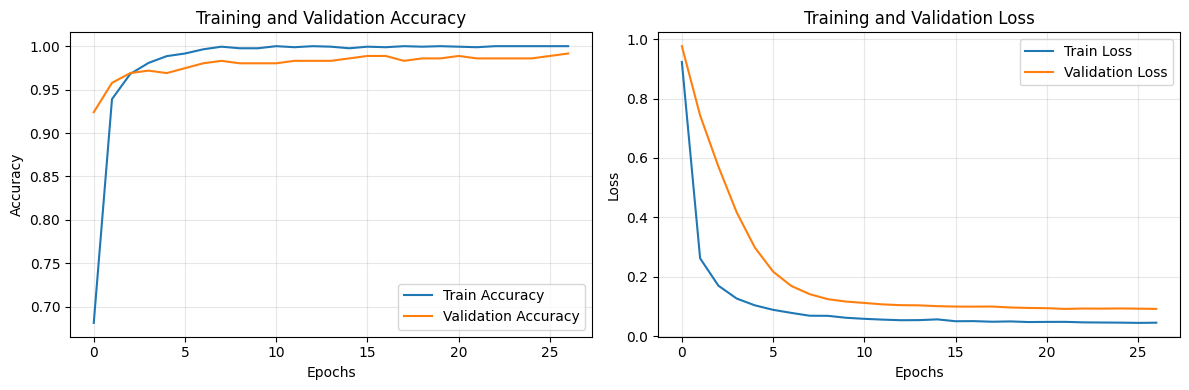

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.grid(True, alpha=0.3)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.grid(True, alpha=0.3)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


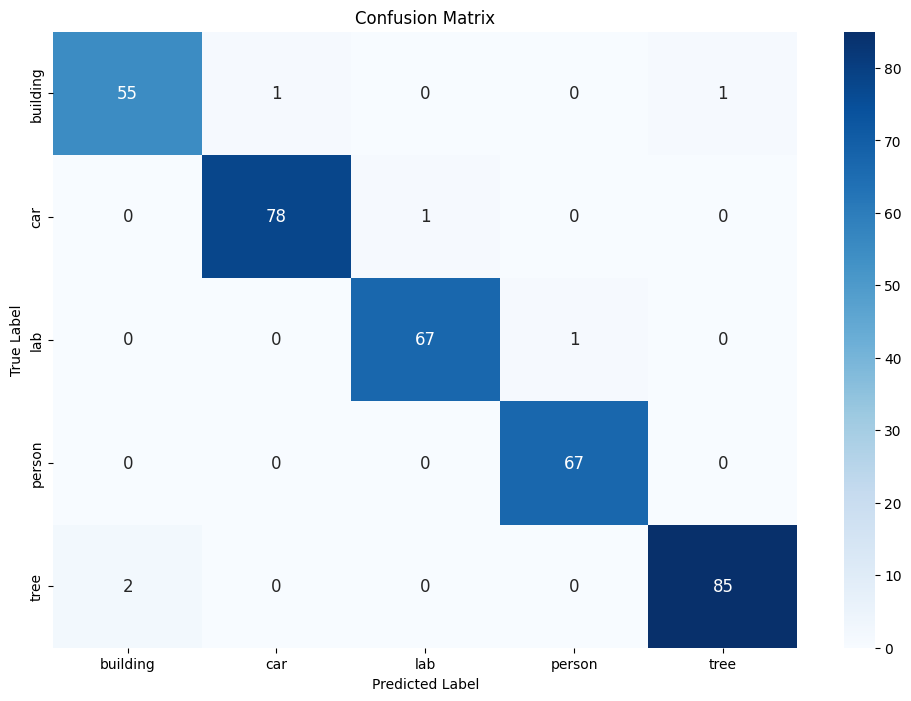

In [33]:
#convision matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(12,8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    annot_kws={"size": 12}
)


plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [34]:
#Number of misclassified images
import numpy as np

misclassified = []

idx = 0  # مؤشر عام

for images, labels in test_ds:
    preds = model_effnet.predict(images, verbose=0)
    pred_labels = np.argmax(preds, axis=1)

    for i in range(len(labels)):
        if labels[i].numpy() != pred_labels[i]:
            misclassified.append((
                images[i].numpy(),
                labels[i].numpy(),
                pred_labels[i]
            ))
        idx += 1

print(f"Number of misclassified images: {len(misclassified)}")


Number of misclassified images: 6


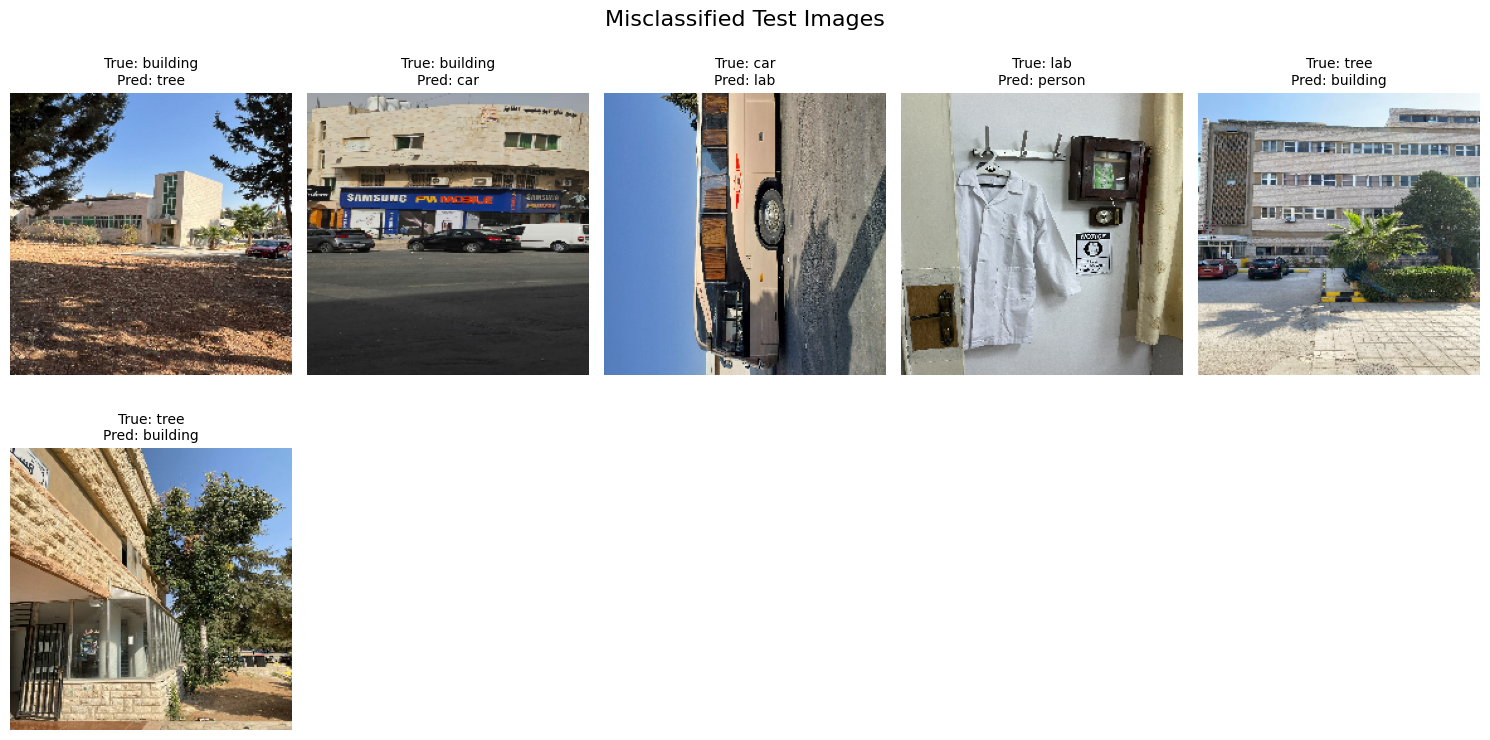

In [36]:
import matplotlib.pyplot as plt

num_show = 6  # عدد الصور اللي  هتنعرض
plt.figure(figsize=(15, 8))

for i in range(min(num_show, len(misclassified))):
    img, true_label, pred_label = misclassified[i]

    plt.subplot(2, 5, i + 1)
    plt.imshow(img.astype("uint8"))
    plt.title(
        f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}",
        fontsize=10
    )
    plt.axis("off")

plt.suptitle("Misclassified Test Images", fontsize=16)
plt.tight_layout()
plt.show()
